# Ungraded Lab: Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

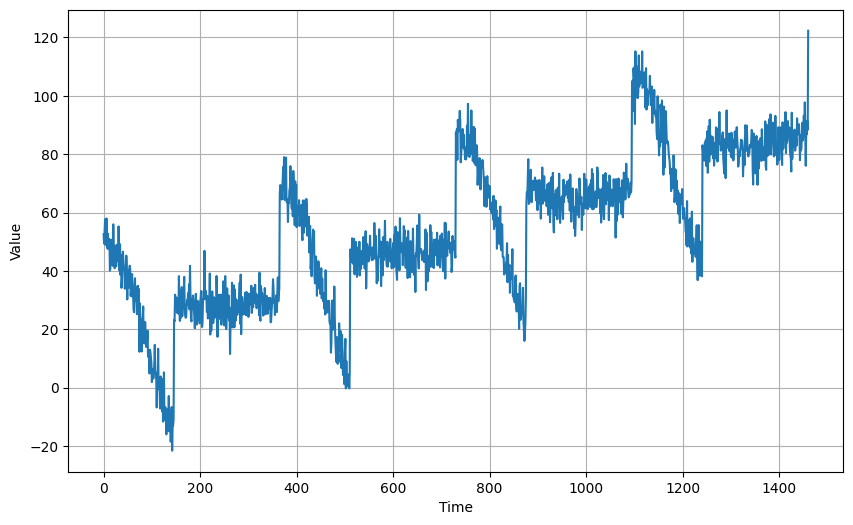

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [8]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [9]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 27.3232 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26.3596 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.1984 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.0026 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.7884 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.6032 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.5068 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.5209 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.6622 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.9382 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

(1e-08, 0.001, 0.0, 30.0)

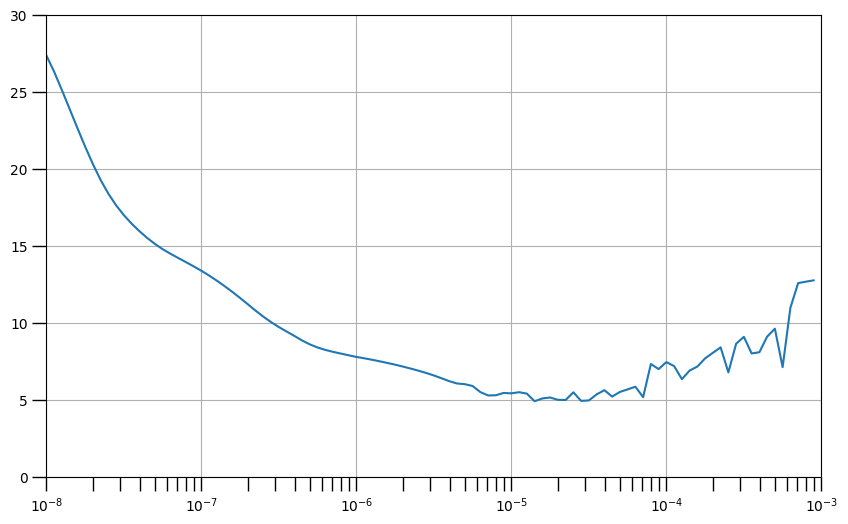

In [10]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

## Train the Model

You can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [11]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 50.4356 - mae: 50.9345
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.8570 - mae: 12.3474
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7381 - mae: 10.2254
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5502 - mae: 9.0390
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8713 - mae: 8.3538
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3889 - mae: 7.8719
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0745 - mae: 7.5531
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8462 - mae: 7.3270
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6535 - mae: 7.1358
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5081 - mae: 6.9919
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3798 - mae: 6.8639
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2592 - mae: 6.7438
Epoch 13/100
31/31 ━━━━━━━━━━━━━

## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [12]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

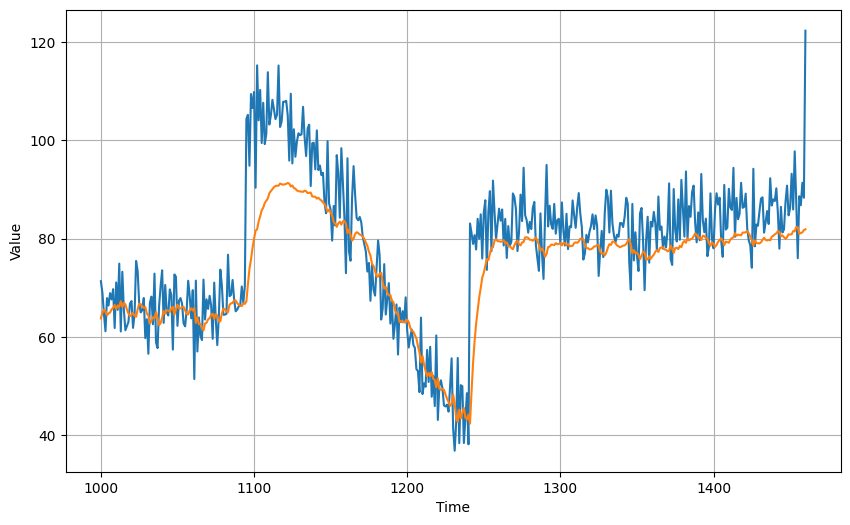

In [13]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [14]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

81.80719
6.5347967


## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!

## Optional: Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab. 

First, you need to generate a `val_set` which are data windows and labels that your model can accept. You can simply reuse the `windowed_dataset` function for that and you can pass in the `x_valid` points to generate the windows.

In [15]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can then do the same training as before but pass in the `val_set` to the `validation_data` parameter of the `fit()` method.

In [16]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 24.6980 - mae: 25.1930 - val_loss: 30.0421 - val_mae: 30.5414
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.2099 - mae: 12.7002 - val_loss: 21.7817 - val_mae: 22.2794
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8198 - mae: 9.3043 - val_loss: 16.3254 - val_mae: 16.8208
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6573 - mae: 8.1331 - val_loss: 13.4901 - val_mae: 13.9837
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2904 - mae: 7.7710 - val_loss: 11.7709 - val_mae: 12.2598
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0840 - mae: 7.5646 - val_loss: 10.9285 - val_mae: 11.4187
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9394 - mae: 7.4208 - val_loss: 10.3333 - val_mae: 10.8238
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8232 - mae: 7.3034 - val_loss: 9.8597 - val_mae: 10.3510
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8m